<a href="https://colab.research.google.com/github/Aritro30/Scaled-Representations-Face-Detection-and-Image-Blending/blob/main/CPSC425Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART 1**

In [ ]:
#import necessary packages
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
from scipy.ndimage import gaussian_filter


    

In [ ]:
#No-1
from zipfile import ZipFile
zip = ZipFile('hw2part1.zip')
zip.extractall()
import ncc


In [ ]:
#No-2
#this function takes in image, scaling factor and minsize and returns a list of numpy arrays
#which are basically the array representation of the images in the pyramid
def MakeGaussianPyramid(image, scale, minsize):
  #x and y are the width and height of the image
  x, y = image.size
  #create double numpy array from the image
  im1_array = np.float32((np.asarray(image)))
  #add the array representation of the original image in the list "l" 
  l = [im1_array]
  #checking whether x or y is greater
  max = x
  if y > max:
    max = y
  #run the while loop until any further reduction in size will make the larger dimension (x or y) of the image smaller than minsize
  while max >= minsize:
    #for greyscale images
    if np.ndim(im1_array) == 2:
      #image array is converted to double for calculations
      im1_array = np.float32(im1_array.copy())  
      #gaussian filter applied on the image array to smooth it
      im1_array = gaussian_filter(im1_array, sigma=1/(2*scale))
      #the image array is converted back to image
      image = Image.fromarray(im1_array)
      #the image is resized with a particular scaling factor
      image = image.resize((int(x*scale),int(y*scale)), Image.BICUBIC)
      #the image is converted back to image array and appended with the list "l"
      im1_array = (np.asarray(image))
      l.append(im1_array)
      #checking whether x or y is greater
      x, y = image.size
      max = x
      if y > max:
        max = y
    #for color images  
    else:
      #the image array is splitted into its color channels
      b, g, r    = im1_array[:, :, 0], im1_array[:, :, 1], im1_array[:, :, 2] # For RGB image
      #gaussian filter is applied on each channel
      b = gaussian_filter(b, sigma=1/(2*scale))
      g = gaussian_filter(g, sigma=1/(2*scale))
      r = gaussian_filter(r, sigma=1/(2*scale))
      #clamping done so that all the values are between 0.0 and 255.0
      b = np.clip(b, a_min = 0.0, a_max = 255.0)
      g = np.clip(g, a_min = 0.0, a_max = 255.0)
      r = np.clip(r, a_min = 0.0, a_max = 255.0)
      #the separated color channels are merged back into array representation of image
      im1_array = np.dstack((b,g,r))
      #clamping done so that all the values are between 0.0 and 255.0 (Not necessary since it was already done)
      im1_array = np.clip(im1_array, a_min = 0.0, a_max = 255.0)
      #array converted to unsigned integer array
      im1_array = np.uint8(im1_array)
      #array converted back to image before resizing with a certain scaling factor
      image = Image.fromarray(im1_array)
      image = image.resize((int(x*scale),int(y*scale)), Image.BICUBIC)
      #image converted back to double numpy image array
      im1_array = np.float32((np.asarray(image)))
      #the array representation is appended to the list "l"
      l.append(im1_array)
      x, y = image.size
      #checking whether x or y is greater
      max = x
      if y > max:
        max = y
  #the created pyramid or list is returned
  return l
#script/test of this function (number-2) shown after code of number-3  

In [ ]:
#No-3
#this function takes in a pyramid or list of arrays which are representation of the images in the pyramid
#it displays the horizontal image version of the pyramid
def ShowGaussianPyramid(pyramid):
  #sum_heights represents height summation of all the images in the pyramid
  sum_heights = 0
  #sum_widths represents width summation of all the images in the pyramid
  sum_widths = 0
  #m represents the height of the first or base image in the pyramid
  #n represents the width of the first or base image in the pyramid
  m,n  = pyramid[0].shape[0], pyramid[0].shape[1]
  #iteratng the image arrays of the pyramid
  for i in pyramid:
    #y and x represents the height and width of each image in the pyramid
    y, x = i.shape[0],i.shape[1]
    #heights and widths summed up in each of its designated variables
    sum_heights = sum_heights + y
    sum_widths = sum_widths + x  
  #empty image created with white background. Width of this image is summation of all the image widths in the pyramid
  #height of the image is the height of the original
  #this is because we are creating a horizontal pyramid
  image1 = Image.new("RGB", (sum_widths, m),(255,255,255))
  #x_offset basically stores the horizontal distance at which the next image of the pyramid will be attached
  #initialized with zero
  x_offset=0
  #accessing each image array in the list/pyramid. 'i' stores the array
  for i in pyramid:
    #clamping of each image array done so that all the values are between 0.0 and 255.0
    image2_array = np.clip(i, a_min = 0.0, a_max = 255.0)
    #double array is converted to unsigned integer array
    image2_array = np.uint8(image2_array)
    #array is converted to image
    image2 = Image.fromarray(image2_array)
    x, y = image2.size
    #image in the pyramid is pasted on to the empty image at required x_offset 
    image1.paste(image2,(x_offset,0))
    x_offset=x_offset+x
  
  return image1



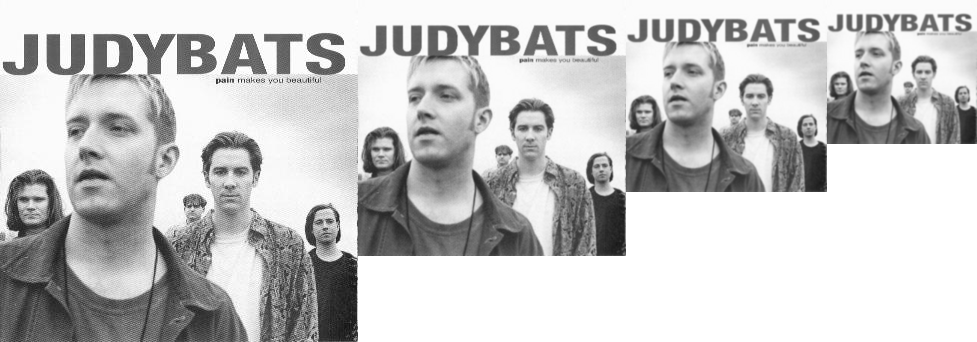

In [ ]:
#Test of number-2 and number-3
#open the sample image
im1 = Image.open('judybats.jpg')
#the gaussian pyramid is created, returned and stored in pyramid
pyramid = MakeGaussianPyramid(im1, 0.75, 200)
#this function displays the pyramid of image arrays
ShowGaussianPyramid(pyramid)


In [ ]:
#number-4
#import necessary packages
from zipfile import ZipFile as zip
import cv2
from matplotlib import pyplot as plt
#this function will mark all the locations in the pyramid where the NCC of the template with image is above threshold
#it takes in 3 inputs 1) pyramid 2) template 3) threshold
def FindTemplate(pyramid, template, threshold):
  #we will detect objects/mark rectangles/match templates on the original base image of the pyramid
  #output array is the first image array in the pyramid
  output_array = pyramid[0]
  #convert the output array into output image
  output = Image.fromarray(output_array)
  #x and y are template width and height respectively
  x,y = template.size
  #'scale' represents by what factor, x and y should be multiplied to reduce template size to 15 pixels
  scale = 15/x
  #resizing the template 
  template = template.resize((int(x*scale),int(y*scale)), Image.BICUBIC)
  #power stores the power by which each rectangular match in different levels of pyramid must be magnified.
  power = 0
  #accessing each array in the list/pyramid
  for z in pyramid:
    #convert each array in the pyramid into its image representation ('z_img')
    z_img = Image.fromarray(z)
    #compute the NCC and store the values in nxcorr
    nxcorr = ncc.normxcorr2D(z_img, template)
    #detect the values which are greater than the threshold set
    loc = np.where( nxcorr >= threshold)
    #convert the output image into RGB so that 'red' rectangles can be drawn when template matches  
    output = output.convert('RGB')
    #temp_x,temp_y are template width and height respectively
    temp_x,temp_y = template.size
    #loc basically stores tuple that contains the x-cordinates (index 0) and y-coordinates (index 1) in each image of the pyramid 
    #that are higher than the threshold. We iterate through the length of the zero index to travel through all the coordinates 
    #of each image that are higher than the threshold.
    for i in range(len(loc[0])):
      #(loc[0][i],loc[1][i]) is the position in each image of the pyramid around which a rectangle must be drawn
      #(x1,y1) is 7.5 pixels to left of the symmetry
      #(x2,y2) is 7.5 pixels to right of the symmetry
      #proper magnification of the template with 'power' is done so that the template fits in the original image
      y1 = (0.75**-power)*(loc[0][i] - temp_y/2)    
      x1 = (0.75**-power)*(loc[1][i] - temp_x/2)
      y2 = (y1 +  temp_y*(0.75**-power))
      x2 = (x1 + temp_x*(0.75**-power))
      #rectangle is drawn by selecting the appropriate coordinates
      draw = ImageDraw.Draw(output)
      draw.line((x1,y1,x1,y2),fill="red",width=2)
      draw.line((x1,y1,x2,y1),fill="red",width=2)
      draw.line((x2,y1,x2,y2),fill="red",width=2)
      draw.line((x1,y2,x2,y2),fill="red",width=2)
    power += 1
  #display the matched output  
  display(output)


/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


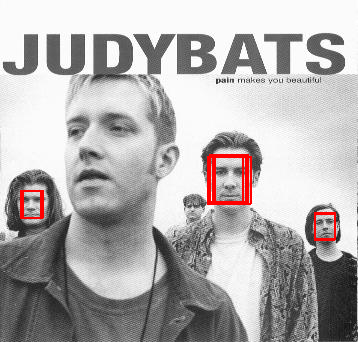

In [ ]:
#test code
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('judybats.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
FindTemplate(x, template, 0.7)    


My selected threshold is **0.6**

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


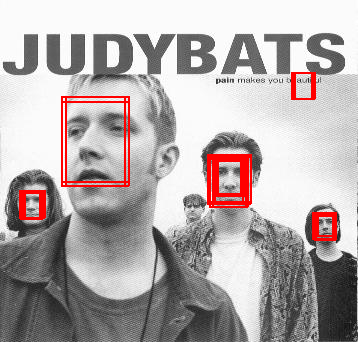

In [ ]:
#test 1
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('judybats.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
FindTemplate(x, template, 0.6)    


/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


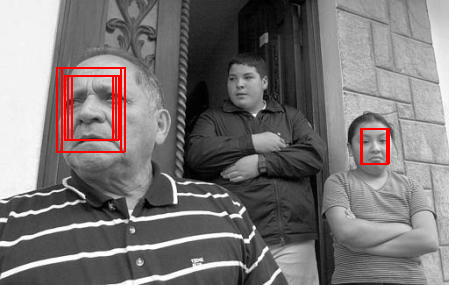

In [ ]:
#test 2
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('family.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
FindTemplate(x, template, 0.6)    


/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


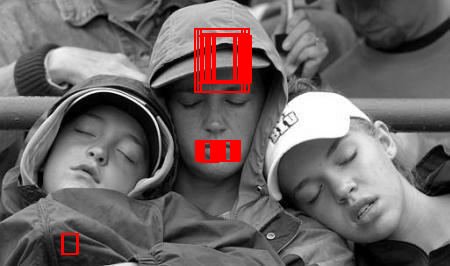

In [ ]:
#test 3
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('fans.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
FindTemplate(x, template, 0.6)    


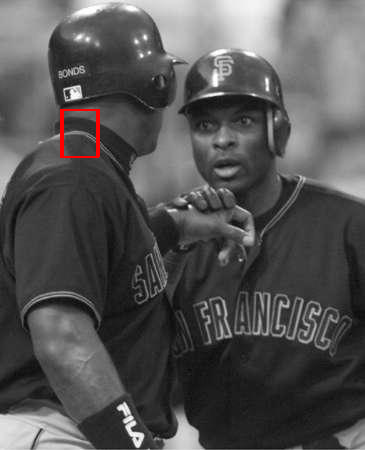

In [ ]:
#test 4
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('sports.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
#ShowGaussianPyramid(x)
FindTemplate(x, template, 0.6)    


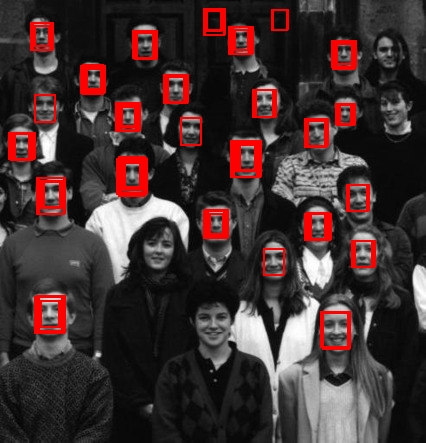

In [ ]:
#test 5
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('students.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
FindTemplate(x, template, 0.6)    


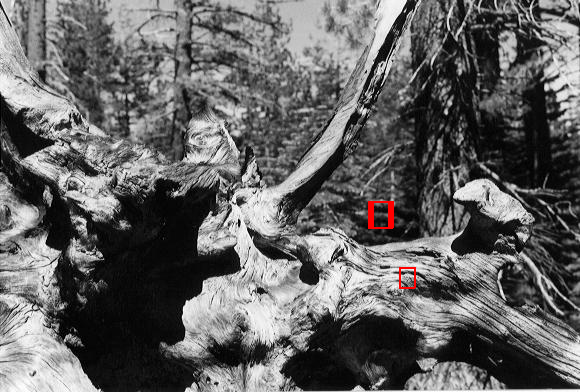

In [ ]:
#test 6
#open the template image  
template = Image.open('face_detection_template.jpg')
#open the sample image to be used for template matching
im = Image.open('tree.jpg')
#create the Gaussian pyramid and store it in x
x = MakeGaussianPyramid(im, 0.75, 70)
#find the match
FindTemplate(x, template, 0.6)    


No-6

Recall (Image-1) = True Positive / (relevant elements) = 4/(4+1) = 0.8

Recall (Image-2) = True Positive / (relevant elements) = 2/(2+1) = 0.67

Recall (Image-3) = True Positive / (relevant elements) = 1/(1+2) = 0.33

Recall (Image-4) = True Positive / (relevant elements) = 0/(0+1) = 0

Recall (Image-5) = True Positive / (relevant elements) = 23/(23+4) = 0.85

Recall (Image-6) = True Positive / (relevant elements) = 0 = 0


Some of the images (say for e.g: the last image (6)) is having low recall due to the fact that it does not contain a single face against which we can match the template. As a result, the number of true positives is zero. The numerator while calculating the recall rate becomes zero. Hence, the recall rate is also very low.

Another reason can be different level of brightness of the template and the image we want to match. This may result in less true positives, hence, less recall rate.

# **PART 2**

In [ ]:
#No-1 
#import necessary packages
from zipfile import ZipFile 
zip = ZipFile('hw2part2.zip')
zip.extractall()


In [ ]:
#No-2
#this function returns the Laplacian pyramid
def MakeLaplacianPyramid(image, scale, minsize):
  #first the gaussian pyramid is created for the sample image
  gauss_pyramid = MakeGaussianPyramid(image, scale, minsize)
  #"l" is the list that will contains the arrays of the images in the laplacian pyramid
  l=[]
  #level counts the level of the pyramid
  level = 0
  for i in gauss_pyramid:
    #checking whether it is a color image
    if np.ndim(i) == 3:
      #we create laplacian representations for all the levels except the last one
      #checking whether the level is not the last level
      if level != len(gauss_pyramid)-1:
        #splitting the color channels
        #calculating the laplacian representation of each image(color channel) 
        #by subtracting filtered version of the image(color channel) in the gaussian pyramid from the image(color channel) itself
        b, g, r    = i[:, :, 0], i[:, :, 1], i[:, :, 2]
        b = b - gaussian_filter(b,sigma=1/(2*scale)) 
        g = g - gaussian_filter(g,sigma=1/(2*scale)) 
        r = r - gaussian_filter(r,sigma=1/(2*scale))
        #combining the color channels
        im1_array = np.dstack((b,g,r))
        #appending the image array to the list
        l.append(im1_array)
      else:
        #if it is the last level of gaussian pyramid, no need to compute the subtraction 
        l.append(i)  
    else:
      #for greyscale images
      #we create laplacian representations for all the levels except the last one
      #checking whether the level is not the last level
      if level != len(gauss_pyramid)-1:
        #clipping to ensure that all values are within range of 0 and 255
        im1_array = np.clip((i-gaussian_filter(i,sigma=1/(2*scale))), a_min = 0.0, a_max = 255.0)
        #appending the image array to the list
        l.append(im1_array)    
      else:
        #if it is the last level of gaussian pyramid, no need to compute the subtraction
        l.append(i)
    level+=1     
  #return the created pyramid or list
  return l


In [ ]:
#No-3
#this function is used to show the laplacian pyramid that is created
def ShowLaplacianPyramid(pyramid):
  #sum_heights represents height summation of all the images in the pyramid
  #sum_widths represents width summation of all the images in the pyramid
  #both of them initialized with zeros
  sum_heights = 0
  sum_widths = 0
  #m represents the height of the first or base image in the pyramid
  #n represents the width of the first or base image in the pyramid
  m,n  = pyramid[0].shape[0],pyramid[0].shape[1]
  #iteratng the image arrays of the pyramid
  for i in pyramid:
    #y and x represents the height and width of each image in the pyramid
    y, x = i.shape[0],i.shape[1]
    #heights and widths summed up in each of its designated variables
    sum_heights = sum_heights + y
    sum_widths = sum_widths + x  
  #empty image created with white background. Width of this image is summation of all the image widths in the pyramid
  #height of the image is the height of the first/base image in the pyramid
  #this is because we are creating a horizontal pyramid
  image1 = Image.new("RGB", (sum_widths, m),(255,255,255))  
  #check whether it is a greyscale image
  if np.ndim(pyramid[0]) == 2:
    #x_offset basically stores the horizontal distance at which the next image of the pyramid will be attached
    #initialized with zero  
    x_offset=0
    level = 0
    #accessing each image array in the list/pyramid. 'i' stores the array
    for i in pyramid:
      #checking whether it is not the last image in the pyramid
      #if not we add 128 because laplacian images are within -128 to +128
      if  level != (len(pyramid)-1):
        i = i + 128
      #clamping of each image array done so that all the values are between 0.0 and 255.0
      image2_array = np.clip(i, a_min = 0.0, a_max = 255.0)
      #double array is converted to unsigned integer array
      image2_array = np.uint8(image2_array)
      #array is converted to image
      image2 = Image.fromarray(image2_array)
      x, y = image2.size 
      #image in the pyramid is pasted on to the empty image at required x_offset
      image1.paste(image2,(x_offset,0))
      x_offset=x_offset+x
      level += 1
  #if color image    
  else:
    #x_offset basically stores the horizontal distance at which the next image of the pyramid will be attached
    #initialized with zero  
    x_offset=0
    level = 0
    for i in pyramid:
      #splitting color image into its color channels
      b, g, r    = i[:, :, 0], i[:, :, 1], i[:, :, 2]
      #checking whether it is not the last image in the pyramid
      #if not we add 128 because laplacian images are within -128 to +128
      if  level != (len(pyramid)-1):
        b = b + 128
        g = g + 128
        r = r + 128
      #clamping of each image array done so that all the values are between 0.0 and 255.0
      b = np.clip(b, a_min = 0.0, a_max = 255.0)
      g = np.clip(g, a_min = 0.0, a_max = 255.0)
      r = np.clip(r, a_min = 0.0, a_max = 255.0)
      #combining the color channels
      image2_array = np.dstack((b,g,r))
      #double array is converted to unsigned integer array
      image2_array = np.uint8(image2_array)
      #array is converted to image
      image2 = Image.fromarray(image2_array)
      x, y = image2.size 
      #image in the pyramid is pasted on to the empty image at required x_offset
      image1.paste(image2,(x_offset,0))
      x_offset=x_offset+x
      level+=1          
  display(image1)


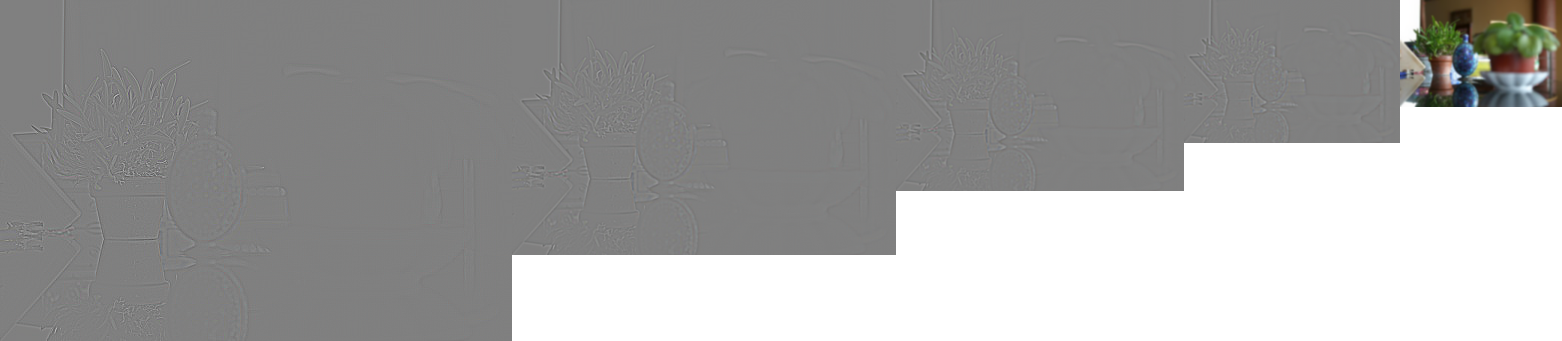

In [ ]:
#test1
#open the image
image = Image.open('orchid.jpg')
#create laplacian pyramid
pyramid = MakeLaplacianPyramid(image, 0.75, 200)
#show the pyramid
ShowLaplacianPyramid(pyramid)


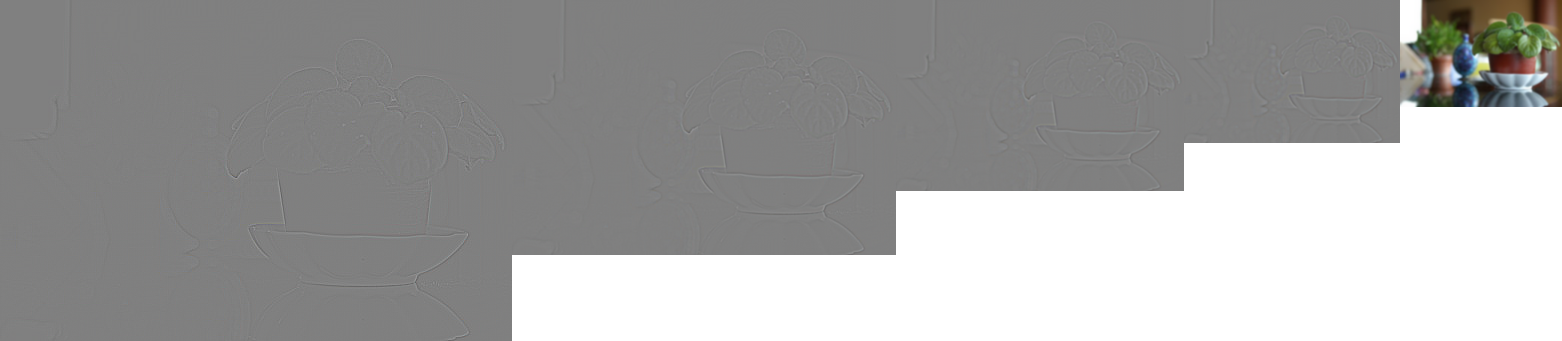

In [ ]:
#test2
#open the image
image = Image.open('violet.jpg')
#create laplacian pyramid
pyramid = MakeLaplacianPyramid(image, 0.75, 200)
#show the laplacian pyramid
ShowLaplacianPyramid(pyramid)


In [ ]:
#No-4
#this function reconstructs gaussian pyramid from the laplacian pyramid
def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  #it traverses the laplacian pyramid in reverse. Starts from the last/top of the pyramid
  for i in range (len(lPyramid)-1,0,-1): 
    #array in the pyramid is converted to image
    im = Image.fromarray(np.uint8(lPyramid[i]))
    #magnification to the next level is done
    im = im.resize((lPyramid[i-1].shape[1],lPyramid[i-1].shape[0]), Image.BICUBIC)
    #magnified image converted to array again
    x = np.asarray(im)
    #array splitted up into its color channels
    b1, g1, r1    = x[:, :, 0], x[:, :, 1], x[:, :, 2]
    #already existing laplacian representation of next level is splitted into color channels
    b2, g2, r2    = lPyramid[i-1][:, :, 0], lPyramid[i-1][:, :, 1], lPyramid[i-1][:, :, 2]
    #color channels of the two representations are summed up
    combined_b = b1 + b2 
    combined_g = g1 + g2 
    combined_r = r1 + r2 
    #color channels cobined together and appropriate clipping is done
    lPyramid[i-1] = np.dstack((combined_b,combined_g,combined_r)) 
    lPyramid[i-1] = np.clip(lPyramid[i-1], a_min = 0, a_max = 255)  
  #the recontructed pyramid is returned 
  return lPyramid      


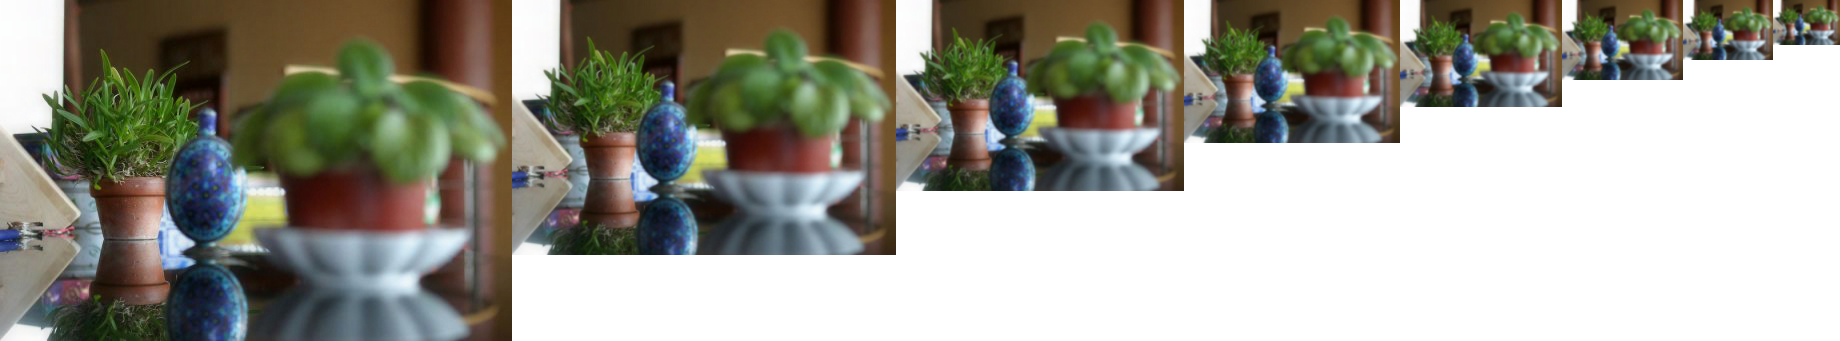

In [ ]:
#open the image
image = Image.open('orchid.jpg')
#create laplacian pyramid
pyramid = MakeLaplacianPyramid(image, 0.75, 70)
#reconstruct the gaussian pyramid
gPyramid = ReconstructGaussianFromLaplacianPyramid(pyramid)
display(ShowGaussianPyramid(gPyramid))


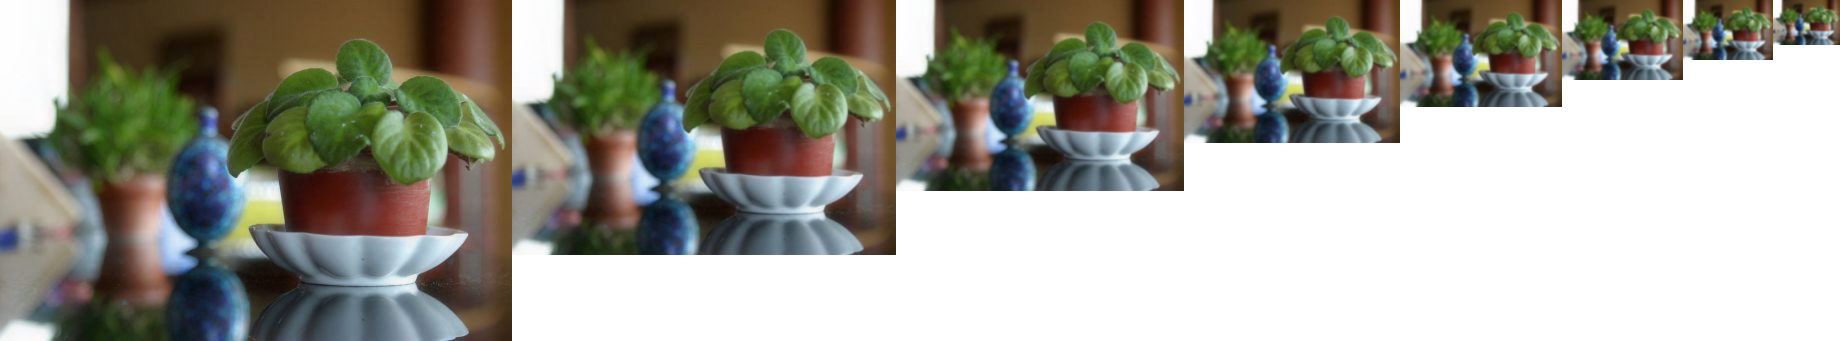

In [ ]:
#open the image
image = Image.open('violet.jpg')
#create laplacian pyramid
pyramid = MakeLaplacianPyramid(image, 0.75, 70)
#reconstruct the gaussian pyramid
gPyramid = ReconstructGaussianFromLaplacianPyramid(pyramid)
display(ShowGaussianPyramid(gPyramid))


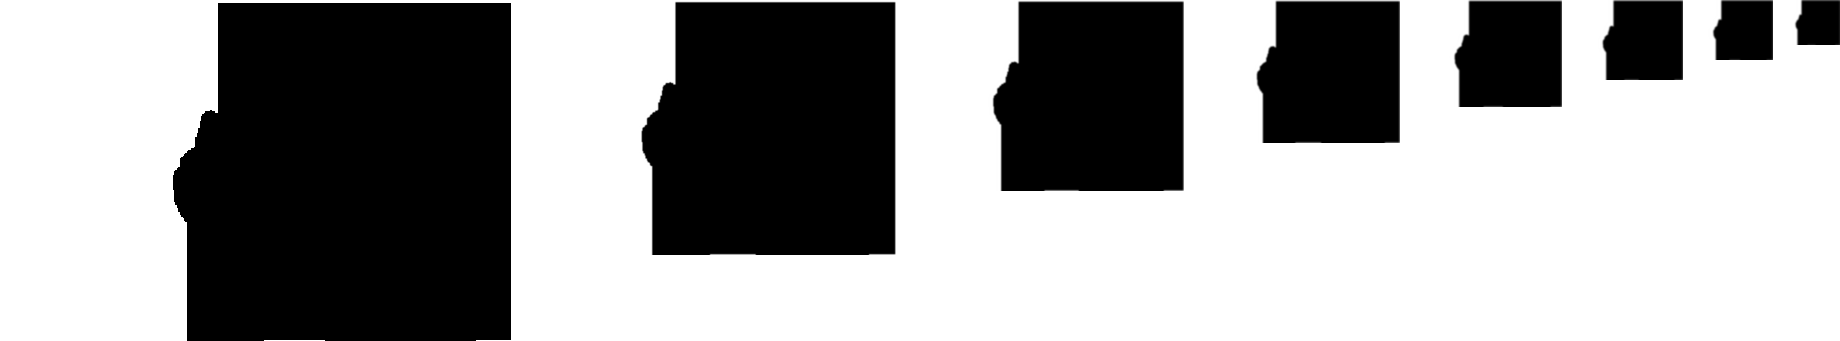

In [ ]:
#No-5
#open the image
image = Image.open('orchid_mask.bmp')
#create gaussian pyramid
pyramid = MakeGaussianPyramid(image, 0.75, 70)
#show gaussian pyramid
ShowGaussianPyramid(pyramid)

In [ ]:
#No-6
#it takes in two laplacian pyramids and a gaussian pyramid that represents the mask
def CreateImageBlend(lapA, lapB, gaussianM):
  #it is the output pyramid that we will generate after blending the images and masks
  compLaplacian = []
  #iterating the indices of laplacian pyramid
  #note - all the pyramids are of the same size
  for i in range(len(lapA)):
    #splitting the color channels
    #computations will be performed per channel
    b1, g1, r1    = lapA[i][:, :, 0], lapA[i][:, :, 1], lapA[i][:, :, 2]
    b2, g2, r2    = lapB[i][:, :, 0], lapB[i][:, :, 1], lapB[i][:, :, 2]
    mask    = gaussianM[i]
    #appropriate blending computation is done
    compLaplacianB = b1 * mask/255 +  b2 * (1 - mask/255)
    compLaplacianG = g1 * mask/255 +  g2 * (1 - mask/255)
    compLaplacianR = r1 * mask/255 +  r2 * (1 - mask/255)
    #ensuring all values are within 0 and 255 to avoid artifacts
    compLaplacianB = np.clip(compLaplacianB, a_min = 0.0, a_max = 255.0)
    compLaplacianG = np.clip(compLaplacianG, a_min = 0.0, a_max = 255.0)
    compLaplacianR = np.clip(compLaplacianR, a_min = 0.0, a_max = 255.0)
    #the color channels are merged together and the array is appended to the pyramid/list
    image_array = np.dstack((compLaplacianB,compLaplacianG,compLaplacianR))
    compLaplacian.append(image_array)
  #return the pyramid  
  return compLaplacian
#this function is used to display the first image of the pyramid  
#it takes in the first image as array representation
def ShowGaussianPyramidFirstImage(firstImageArray):
  #clipping done to ensure values are within appropriate range
  blendedImage_array = np.clip(firstImageArray, a_min = 0.0, a_max = 255.0)
  #double array is converted to unsigned integer array
  blendedImage_array = np.uint8(blendedImage_array)
  #array is converted to image
  blendedImage = Image.fromarray(blendedImage_array)
  #display the image
  display(blendedImage)
      


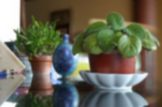

In [ ]:
#open the first image and create laplacian pyramid 
image_orchid = Image.open('orchid.jpg')
X = MakeLaplacianPyramid(image_orchid, 0.75, 200)
#open the second image and create laplacian pyramid
image_violet = Image.open('violet.jpg')
Y = MakeLaplacianPyramid(image_violet, 0.75, 200)
#open the mask and create gaussian pyramid
image_orchid_mask = Image.open('orchid_mask.bmp')
Z = MakeGaussianPyramid(image_orchid_mask, 0.75, 200)
#image blending is done
c = CreateImageBlend(X[4:], Y[4:], Z[4:])
#gaussian pyramid reconstructed from the blended laplacian pyramid
pyramid = ReconstructGaussianFromLaplacianPyramid(c)
#the first/base image of the pyramid is displayed
ShowGaussianPyramidFirstImage(pyramid[0])

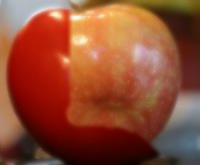

In [ ]:
#No-7
#open the first image and create laplacian pyramid
image_tomato = Image.open('tomato.jpg')
A = MakeLaplacianPyramid(image_tomato, 0.75, 100)
#open the second image and create laplacian pyramid
image_apple = Image.open('apple.jpg')
B = MakeLaplacianPyramid(image_apple, 0.75, 100)
#open the mask and create gaussian pyramid
image_tomato_mask = Image.open('tomato_mask.bmp')
M = MakeGaussianPyramid(image_tomato_mask, 0.75, 100)
#image blending is done
c1 = CreateImageBlend(A, B, M)
#gaussian pyramid reconstructed from the blended laplacian pyramid
pyramid = ReconstructGaussianFromLaplacianPyramid(c1)
#the first/base image of the pyramid is displayed
ShowGaussianPyramidFirstImage(pyramid[0])

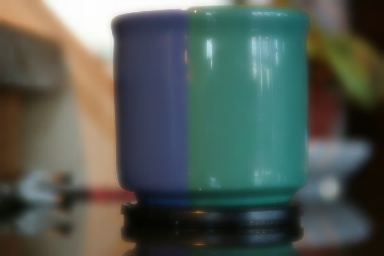

In [ ]:
#open the first image and create laplacian pyramid 
image_blue_cup = Image.open('blue_cup.jpg')
Q = MakeLaplacianPyramid(image_blue_cup, 0.75, 100)
#open the second image and create laplacian pyramid
image_green_cup = Image.open('green_cup.jpg')
#open the mask and create gaussian pyramid
R = MakeLaplacianPyramid(image_green_cup, 0.75, 100)
image_cup_mask = Image.open('cup_mask.bmp')
S = MakeGaussianPyramid(image_cup_mask, 0.75, 100)
#image blending is done
c2 = CreateImageBlend(Q, R, S)
#gaussian pyramid reconstructed from the blended laplacian pyramid
pyramid = ReconstructGaussianFromLaplacianPyramid(c2)
#the first/base image of the pyramid is displayed
ShowGaussianPyramidFirstImage(pyramid[0])

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc


Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "./drive/My Drive/Colab Notebooks/CPSC425Assignment2.ipynb" ./


In [ ]:
!jupyter nbconvert --to PDF "CPSC425Assignment2.ipynb"

[NbConvertApp] Converting notebook CPSC425Assignment2.ipynb to PDF
[NbConvertApp] Support files will be in CPSC425Assignment2_files/
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425Assignment2_files
[NbConvertApp] Making directory ./CPSC425